### NHL inference and simulation with `turf`

---

This notebook runs a hierarchical Bayesian inference model on 2023 NHL season results to estimate team offensive and defensive strengths, visualize the results, and simulate game outcomes.

David Fleming, 2023

In [1]:
import numpy as np
import pymc as pm
import arviz as az
from turf import scrape, utils, inference

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull season results to-date
season = scrape.NHLSeason(year=2023)

In [3]:
# Initialize model
model = inference.IndependentNegativeBinomialMixture(season)

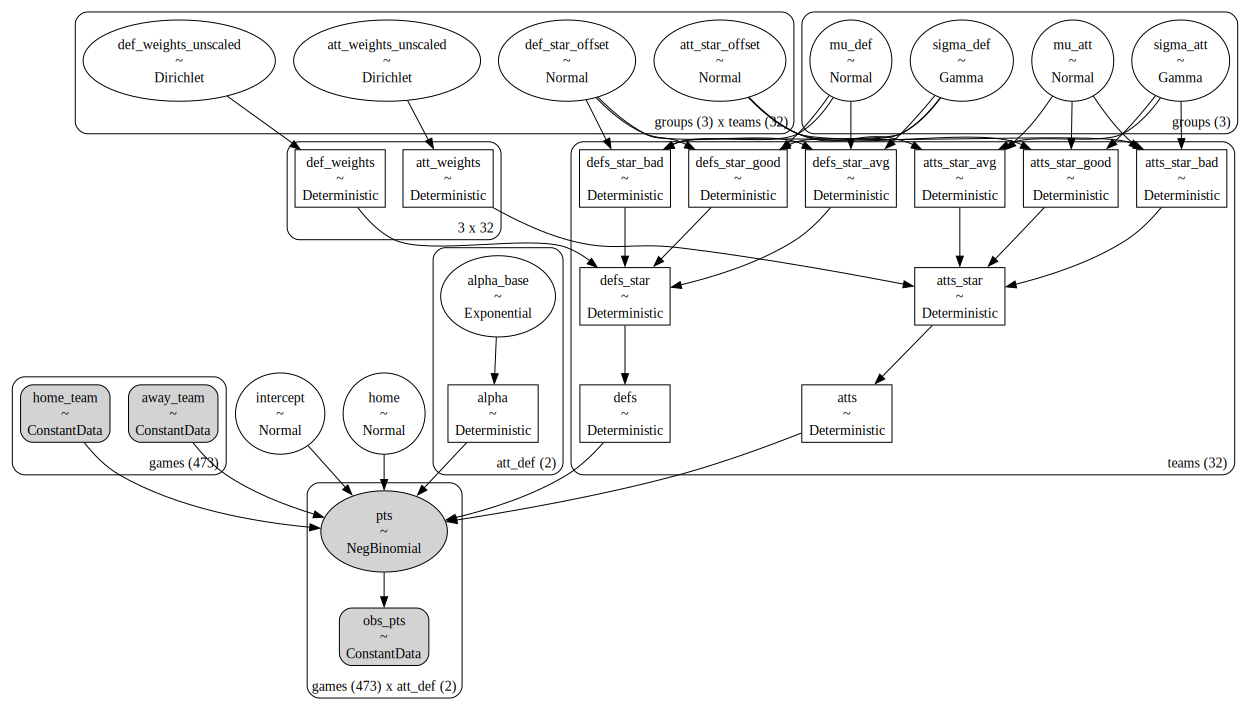

In [4]:
# Visualize model
pm.model_graph.model_to_graphviz(model.model)

In [5]:
# Run inference on 4 cores (1 chain per core)
model.run_inference(tune=2000, draws=1000, target_accept=0.95, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, att_weights_unscaled, def_weights_unscaled, mu_att, mu_def, sigma_att, sigma_def, alpha_base, att_star_offset, def_star_offset]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 83 seconds.


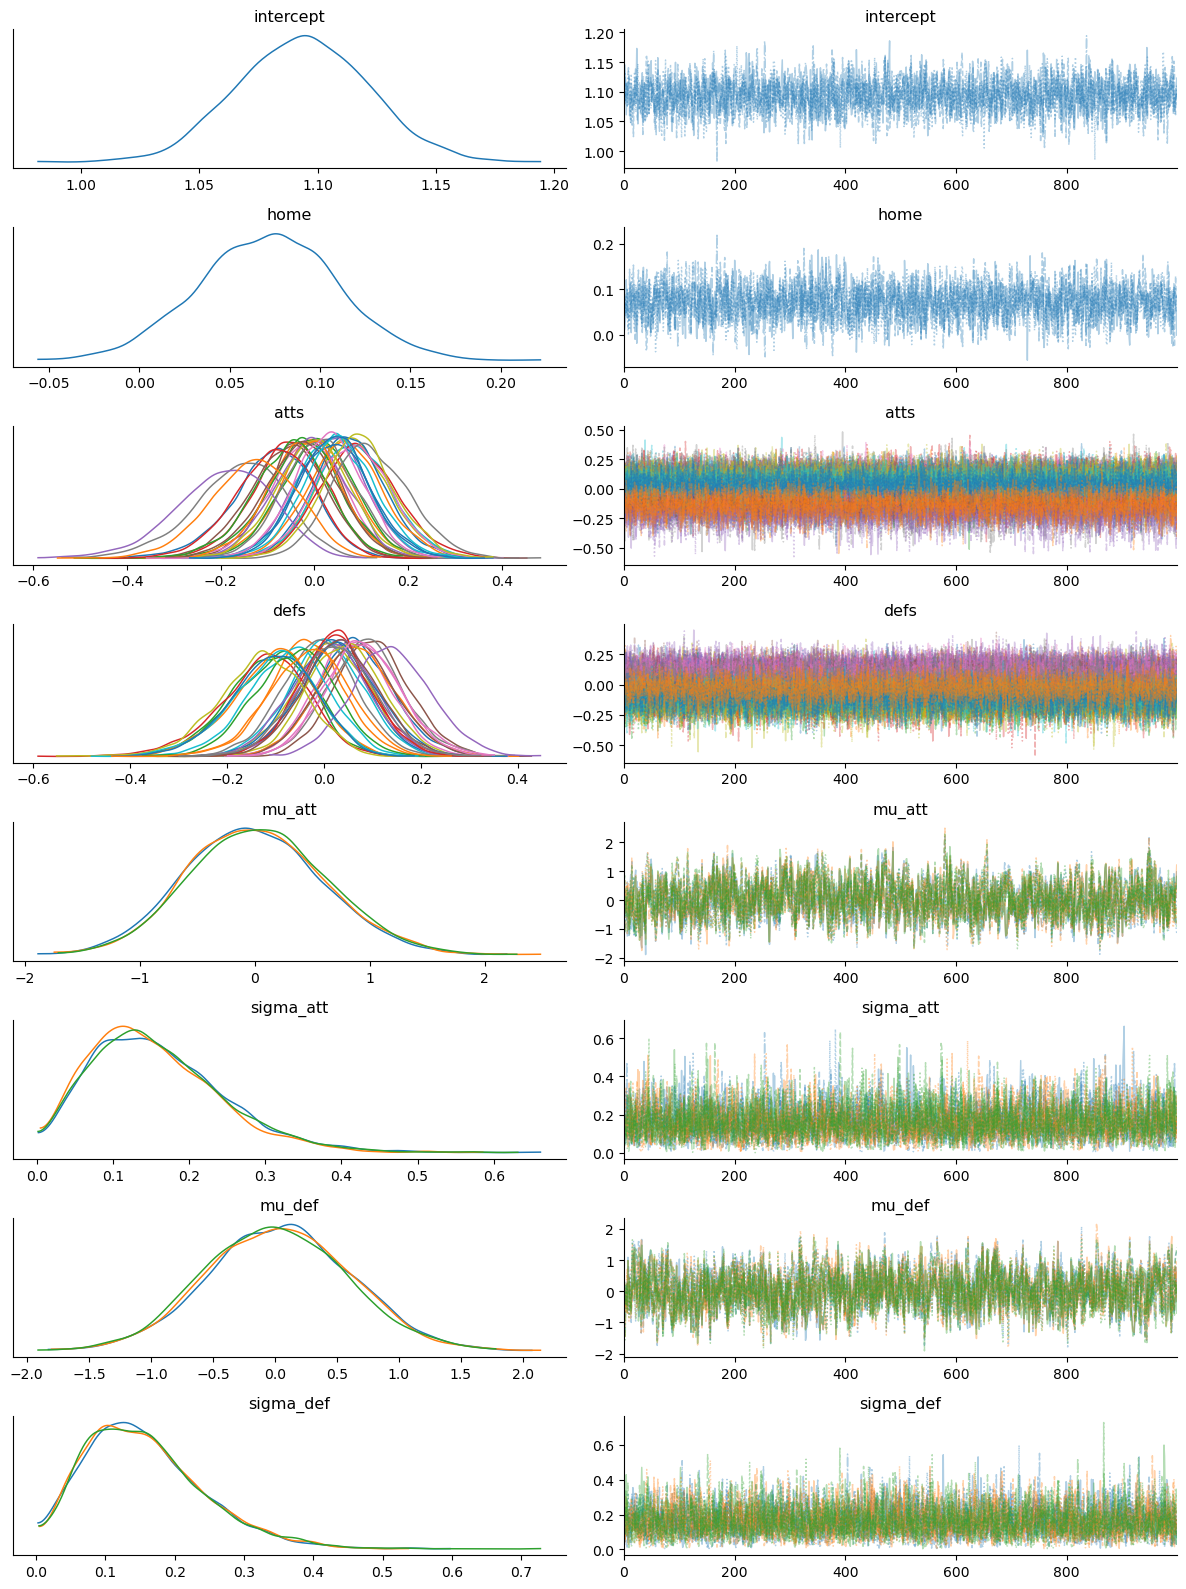

In [6]:
# Examine full posterior distributions and trace for select parameters
axes = az.plot_trace(model.trace_, compact=True, var_names=["intercept", "home",
                                                            "atts", "defs", "mu_att", "sigma_att",
                                                            "mu_def", "sigma_def"],
                     combined=True)

for ii in range(axes.shape[0]):
    for jj in range(axes.shape[1]):
        ax = axes[ii,jj]
        sns.despine(ax=ax)
ax.get_figure().tight_layout()

In [7]:
# Examine MCMC statistics to check convergence
az.summary(model.trace_, group='posterior', var_names=['mu'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_att[bad],-0.014,0.590,-1.096,1.115,0.019,0.014,962.0,1484.0,1.0
mu_att[average],0.014,0.590,-1.053,1.169,0.020,0.014,909.0,1535.0,1.0
mu_att[good],0.044,0.591,-1.016,1.177,0.019,0.014,929.0,1660.0,1.0
mu_def[bad],0.045,0.575,-1.013,1.153,0.018,0.013,1014.0,1708.0,1.0
mu_def[average],0.031,0.575,-1.053,1.073,0.018,0.013,989.0,2071.0,1.0
mu_def[good],-0.005,0.573,-1.040,1.113,0.018,0.013,999.0,1557.0,1.0


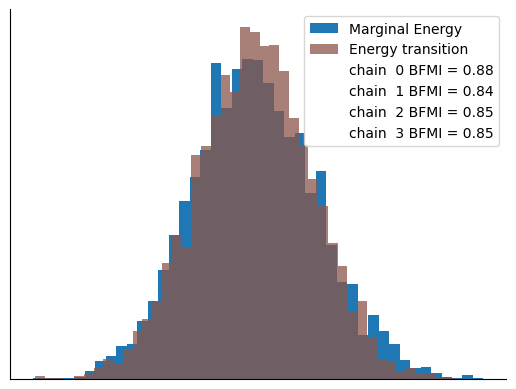

In [8]:
# Same as above, but visualizing energy of chain transition
# Should be ~1 for good convergence
ax = az.plot_energy(model.trace_, kind='hist')
sns.despine(ax=ax)

In [9]:
# Team names, medians, CIs, and colors
team_names = model.trace_.posterior.coords['teams'].values

# Calculate median, 68% CI for atts, defs for each team
med_atts = model.trace_.posterior["atts"].median(axis=1).median(axis=0).values
med_defs = model.trace_.posterior["defs"].median(axis=1).median(axis=0).values

# Calculate median, 68% CI for atts, defs for each team, convert to numpy arrays
defs_CI = az.hdi(model.trace_, var_names=["defs"], hdi_prob=0.68)
defs_CI = defs_CI.to_array().values[0]

atts_CI = az.hdi(model.trace_, var_names=["atts"], hdi_prob=0.68)
atts_CI = atts_CI.to_array().values[0]

# Get primary and secondary colors for pretty plots
pri_colors = list(map(lambda x : utils._hex_color_nhl[f"{x}_0"], team_names))
sec_colors = list(map(lambda x : utils._hex_color_nhl[f"{x}_1"], team_names))

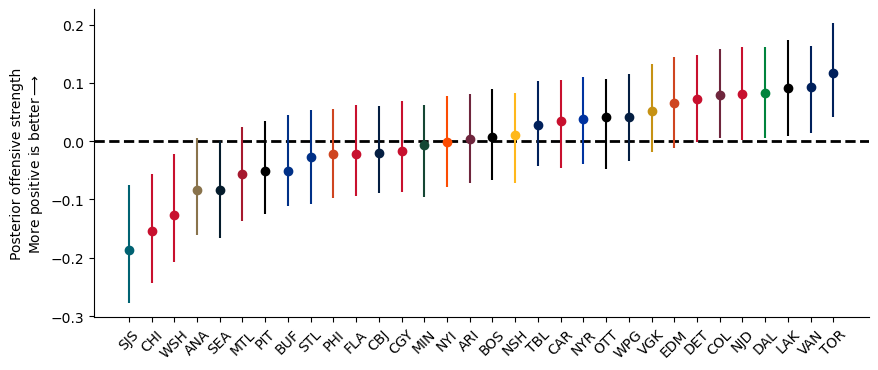

In [10]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_atts)

x = np.arange(len(med_atts))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_atts[inds[ii]], 
                yerr=np.asarray([med_atts[inds[ii]] - atts_CI[inds[ii],0], atts_CI[inds[ii],1] - med_atts[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('')
ax.set_ylabel('Posterior offensive strength\nMore positive is better$\longrightarrow$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

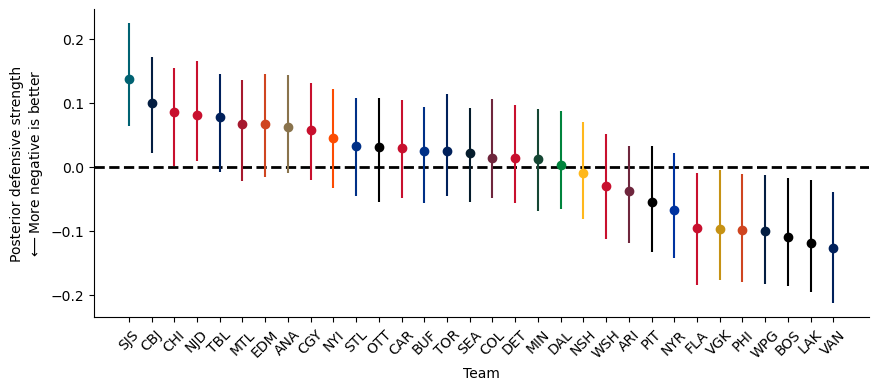

In [11]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_defs)[::-1]

x = np.arange(len(med_defs))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_defs[inds[ii]], 
                yerr=np.asarray([med_defs[inds[ii]] - defs_CI[inds[ii],0], defs_CI[inds[ii],1] - med_defs[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('Team')
ax.set_ylabel('Posterior defensive strength\n$\longleftarrow$More negative is better')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

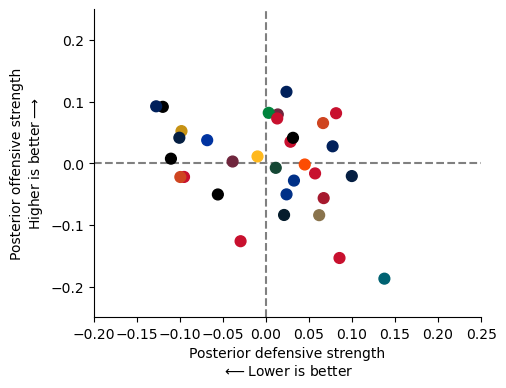

In [12]:
# Plot offensive and defensive strength together
fig, ax = plt.subplots(figsize=(5,4))

im = ax.scatter(med_defs, med_atts, s=60, zorder=1, c=pri_colors)
ax.axhline(0, lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

ax.set_xlabel('Posterior defensive strength\n$\longleftarrow$Lower is better')
ax.set_ylabel('Posterior offensive strength\nHigher is better$\longrightarrow$')
ax.set_xlim(-0.2, 0.25)
ax.set_ylim(-0.25, 0.25)
sns.despine(ax=ax)

**Simulate many games**

---

Simulate NFL results to estimate who will win, with what probability, and similar inferences for over/unders, moneyline, and spreads.

In [13]:
away_teams = ["CHI"]
home_teams = ["STL"]
ous = [6.5]
home_spread = [-0.5]

for home_team, away_team, ou, hs, ii, in zip(home_teams, away_teams, ous, home_spread, np.arange(len(home_teams))):

    # Simulate n game outcomes
    home_pts, away_pts, home_win, tie = model.simulate_game(home_team, away_team, n=10000, seed=None)
    
    total = home_pts + away_pts
    odds = np.mean(total > ou)
    cover = np.mean(home_pts - away_pts > -hs)
    home_ml = np.mean(home_pts > away_pts)
    
    print(f"---{away_team} at {home_team}---")
    print(f"O/U: {ou} - Over odds : {np.round(100*odds, decimals=2):.2f}%")
    print(f"Spread: {home_team} {home_spread[ii]} - odds of {home_team} cover : {np.round(100*cover, decimals=2):.2f}%") 
    print(f"ML: - odds of {home_team} ML : {np.round(100*home_ml, decimals=2):.2f}%")
    print(f"Median outcome: {away_team} {np.median(away_pts):.0f} | {home_team} {np.median(home_pts):.0f}")
    print()

---CHI at STL---
O/U: 6.5 - Over odds : 40.76%
Spread: STL -0.5 - odds of STL cover : 53.84%
ML: - odds of STL ML : 53.84%
Median outcome: CHI 2 | STL 3



**Examine posterior predictive distribution**

---

Simple model evaluation method to see if model can reproduce season total points distribution.

In [14]:
# Sample from posterior predictive distribution
with model.model:
    model.trace_.extend(pm.sample_posterior_predictive(model.trace_))

Sampling: [pts]


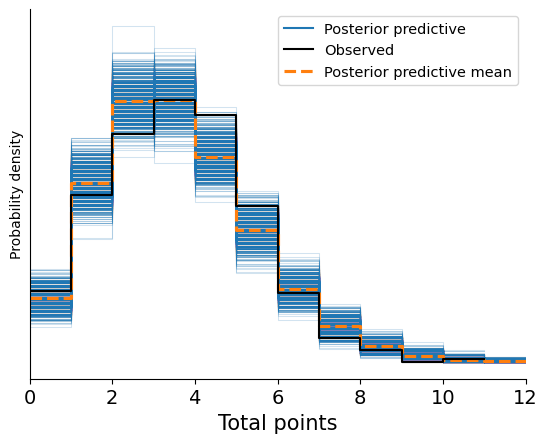

In [15]:
ax = az.plot_ppc(model.trace_, kind='kde', num_pp_samples=1000, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 12)
ax.set_xlabel("Total points")
ax.set_ylabel("Probability density");

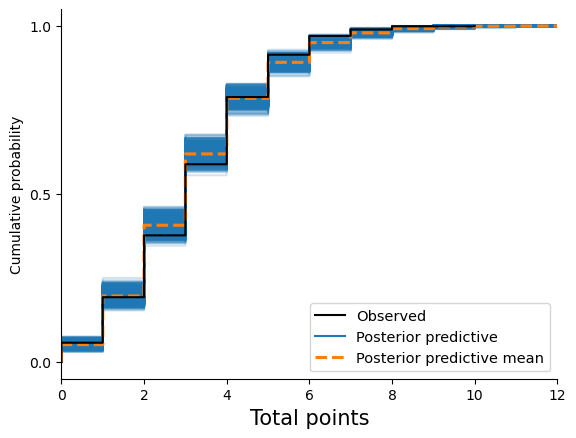

In [16]:
ax = az.plot_ppc(model.trace_, kind='cumulative', num_pp_samples=1000, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 12)
ax.set_xlabel("Total points")
ax.set_ylabel("Cumulative probability");